## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [2]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

In [3]:
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

In [4]:
B_homes.head()

,longitude,latitude,country,user
user_id,,,,
0,-105.009140,39.756108,US,0
1,-122.353819,37.581821,US,1
2,-105.041977,39.771737,US,2
3,-122.424280,37.765768,US,3
4,24.937299,60.173985,FI,4


#### Load cities

In [98]:
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)
cities = cities.drop(columns = ['capital', 'admin_name'], axis = 1)

In [64]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82


#### Load edges

In [7]:
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


In [99]:
# 1. Calculate population density
cities['density'] = cities['population'] / cities['area']
n_cities = cities[cities.isnull().any(axis=1)]
n_cities = n_cities[n_cities['population']>50000]

In [100]:
n_cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density
12,New York,New York,40.6943,-73.9249,United States,US,USA,18713220.0,1840034016,NaN,NaN
13,Kolkāta,Kolkata,22.5411,88.3378,India,IN,IND,17560000.0,1356060520,NaN,NaN
29,Nanyang,Nanyang,32.9987,112.5292,China,CN,CHN,12010000.0,1156192287,NaN,NaN
48,Tongshan,Tongshan,34.2610,117.1859,China,CN,CHN,8669000.0,1156241678,NaN,NaN
98,Yichun,Yichun,27.8041,114.3830,China,CN,CHN,6048700.0,1156229590,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11190,Borovichi,Borovichi,58.4000,33.9167,Russia,RU,RUS,50144.0,1643059892,NaN,NaN
11193,Slonim,Slonim,53.0833,25.3167,Belarus,BY,BLR,50100.0,1112619287,NaN,NaN
11194,Roslavl,Roslavl,53.9492,32.8569,Russia,RU,RUS,50112.0,1643356591,NaN,NaN
11195,Gogrial,Gogrial,8.5337,28.1167,South Sudan,SS,SSD,50065.0,1728342889,NaN,NaN


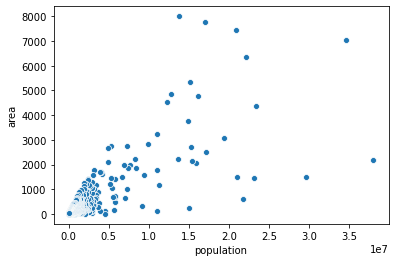

In [102]:
# Estimate missing areas
#a = cities.dropna()
#a = a[(a['population'] > 1000000)&(a['area']<40000)] 
x = np.log(cities['population'])
y = np.log(cities['area'])

sns.scatterplot(data=cities, x='population', y="area")

In [97]:
# cannot predict for unknown population
n_cities = n_cities[~n_cities['population'].isnull()]

In [104]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = cities['population'].values.reshape(-1, 1)
y = cities['area'].values
reg = LinearRegression().fit(X, y)
#reg.score(X, y)
print(reg.intercept_, reg.coef_)

pred_area = reg.predict(n_cities['population'].values.reshape(-1, 1))

46.13812584585452 [0.00017357]


In [113]:
n_cities
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...,...,...,...
11167,Traverse City,Traverse City,44.7547,-85.6035,United States,US,USA,50522.0,1840003946,8.66,5833.949192,1.660290
11169,East Hartford,East Hartford,41.7634,-72.6152,United States,US,USA,50453.0,1840034618,18.70,2698.021390,2.439753
11170,Irondequoit,Irondequoit,43.2096,-77.5705,United States,US,USA,50427.0,1840058201,16.82,2998.038050,2.313865
11179,Mishawaka,Mishawaka,41.6736,-86.1669,United States,US,USA,50363.0,1840014695,17.97,2802.615470,2.391658


In [119]:
# recover the missing areas
n_cities['area'] = pred_area
# merge city data
cities = cities.append(n_cities)
cities['density'] = cities['population'] / cities['area']

In [120]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

In [121]:
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.070000,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.500000,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.000000,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.000000,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.820000,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...,...,...,...
11190,Borovichi,Borovichi,58.4000,33.9167,Russia,RU,RUS,50144.0,1643059892,54.841412,914.345537,4.178105
11193,Slonim,Slonim,53.0833,25.3167,Belarus,BY,BLR,50100.0,1112619287,54.833775,913.670456,4.177814
11194,Roslavl,Roslavl,53.9492,32.8569,Russia,RU,RUS,50112.0,1643356591,54.835858,913.854587,4.177894
11195,Gogrial,Gogrial,8.5337,28.1167,South Sudan,SS,SSD,50065.0,1728342889,54.827700,913.133325,4.177583


In [124]:
# 2. Drop cities with # inhabitants < 50.000 and population density < 1500
cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]

In [129]:
cities = cities.drop_duplicates()
cities

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.070000,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.500000,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.000000,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.000000,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.820000,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...,...,...,...
9582,Hanford,Hanford,36.3274,-119.6549,United States,US,USA,94028.0,1840020382,62.458175,1505.455443,4.458818
9583,Dearborn,Dearborn,42.3127,-83.2129,United States,US,USA,93932.0,1840003969,62.441513,1504.319730,4.458223
9584,Menderes,Menderes,38.2540,27.1340,Turkey,TR,TUR,93796.0,1792033881,62.417908,1502.709766,4.457380
9587,Mikhaylovsk,Mikhaylovsk,45.1283,42.0256,Russia,RU,RUS,93658.0,1643773075,62.393956,1501.074881,4.456525


### Does user live in rural or urban area?

  for each country:
  
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes



In [130]:
# Take a subset for now
B_homes = B_homes.sample(200, random_state=1)
G_homes = G_homes.sample(200, random_state=1)

In [131]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')

In [132]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)


In [133]:
B_merge.head()

,longitude,latitude,country_x,user,city,city_ascii,lat,lng,country_y,iso2,iso3,population,id,area,density,radius,distance_to_city
0,-116.203451,43.6135,US,18790,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,12750807.0,1840020491,4850.00,2629.032371,39.291258,1071.665474
1,-116.203451,43.6135,US,18790,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,5743938.0,1840019440,1407.20,4081.820637,21.164255,2074.975030
2,-116.203451,43.6135,US,18790,Philadelphia,Philadelphia,40.0077,-75.1339,United States,US,USA,5649300.0,1840000673,142.70,39588.647512,6.739645,3401.119974
3,-116.203451,43.6135,US,18790,Houston,Houston,29.7863,-95.3889,United States,US,USA,5464251.0,1840020925,1062.00,5145.245763,18.386003,2399.046326
4,-116.203451,43.6135,US,18790,San Diego,San Diego,32.8312,-117.1225,United States,US,USA,3220118.0,1840021990,372.42,8646.469040,10.887836,1199.531108


In [134]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [135]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [136]:
B_homes.head()
G_homes.head()

,longitude,latitude,country,user,lives_urban
user_id,,,,,
76280,-117.886019,33.801853,US,76280,False
186772,17.227778,62.410301,SE,186772,False
55115,-121.305415,44.064791,US,55115,True
28361,-86.806300,33.482397,US,28361,True
132303,11.984316,57.693889,SE,132303,False


## calculate # friends per user, group by rural/city and compare amount of friends


In [137]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [138]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [139]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
18790,-116.203451,43.613500,US,18790,True,1
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10


## Compare amount of friends for urban/ rural users

In [140]:
B_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,92.0,6.880435,11.100779,1.0,1.0,3.0,8.0,80.0
True,102.0,10.450980,21.526234,1.0,1.0,4.0,8.0,138.0


In [141]:
G_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,121.0,9.297521,19.266398,1.0,2.0,4.0,9.0,150.0
True,68.0,16.352941,41.291018,1.0,2.0,5.0,11.0,317.0


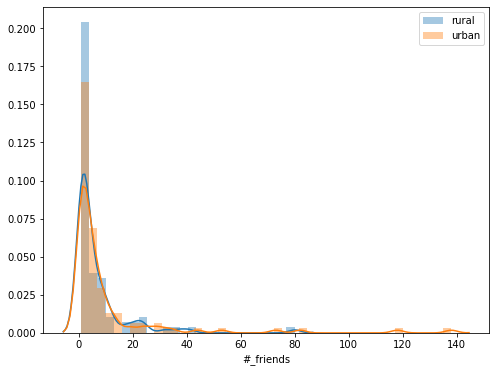

In [142]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural')
sns.distplot(B_urban['#_friends'], label='urban')
plt.legend();

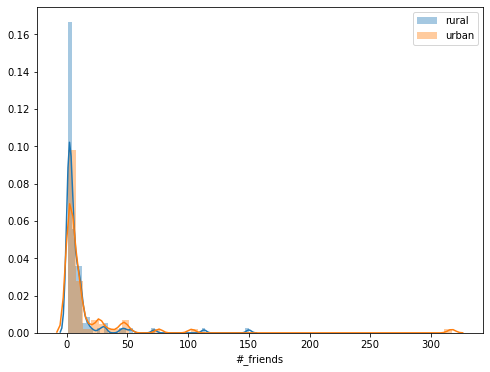

In [143]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(G_rural['#_friends'], label='rural')
sns.distplot(G_urban['#_friends'], label='urban')
plt.legend();